In [10]:
import re
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.metrics import classification_report, confusion_matrix

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from keras import Sequential
from keras.initializers import Constant
from keras.layers import LSTM, Flatten, Dense, Dropout, Embedding
from keras.layers import Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

import gensim
from gensim.models import Word2Vec, KeyedVectors

In [2]:
df = pd.read_csv('./raw_data/fulltrain.csv', header=None, names=['Verdict', 'Text']).sample(frac=1)
df_test = pd.read_csv('./raw_data/balancedtest.csv', header=None, names=['Verdict', 'Text'])

X_train = df['Text']
y_train = df['Verdict']
X_test = df_test['Text']
y_test = df_test['Verdict']

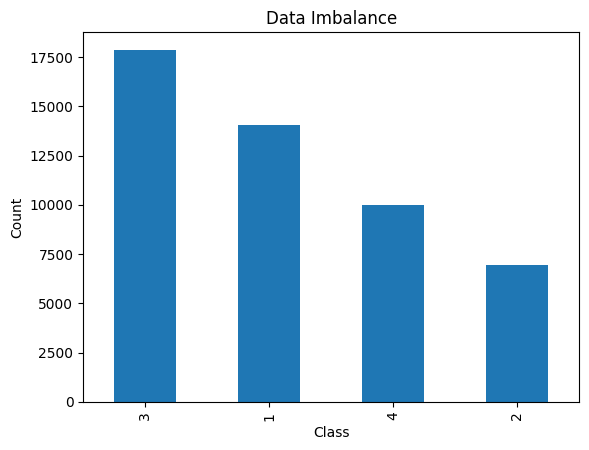

In [3]:
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in y_train
value_counts = y_train.value_counts()

# Plot the data imbalance in a bar chart
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Imbalance')

# Display the bar chart
plt.show()

# Data Cleaning

In [4]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

# Preprocessors
def lowercase(text):
  return text.lower()

def lemmatize(text):
  words = word_tokenize(text)
  return ' '.join([lemmatizer.lemmatize(word) for word in words])

def stem(text):
  words = word_tokenize(text)
  return ' '.join([ps.stem(word) for word in words])

def remove_numbers(text):
  return re.sub(r'\d+', '', text)

def remove_punctuations(text):
  return re.sub(r'[^\w\s]', '', text)

def remove_stopwords(text):
  words = word_tokenize(text)
  return ' '.join([word for word in words if word not in stopwords.words('english')])

Preprocessor = {
    'LOWERCASE': lowercase,
    'LEMMATIZE': lemmatize,
    'STEM': stem,
    'REMOVE_NUMBERS': remove_numbers,
    'REMOVE_PUNCTUATIONS': remove_punctuations,
    'REMOVE_STOPWORDS': remove_stopwords
}

SAMPLE_TEXT = "I am going to bed, my school starts at 8:00."
BEFORE_AND_AFTER_PREPROCESS_LIST = [[preprocessor, SAMPLE_TEXT, Preprocessor[preprocessor](SAMPLE_TEXT)] for preprocessor in Preprocessor]
pd.DataFrame(BEFORE_AND_AFTER_PREPROCESS_LIST, columns=['Preprocessor', 'Before', 'After'])

,Preprocessor,Before,After
0,LOWERCASE,"I am going to bed, my school starts at 8:00.","i am going to bed, my school starts at 8:00."
1,LEMMATIZE,"I am going to bed, my school starts at 8:00.","I am going to bed , my school start at 8:00 ."
2,STEM,"I am going to bed, my school starts at 8:00.","i am go to bed , my school start at 8:00 ."
3,REMOVE_NUMBERS,"I am going to bed, my school starts at 8:00.","I am going to bed, my school starts at :."
4,REMOVE_PUNCTUATIONS,"I am going to bed, my school starts at 8:00.",I am going to bed my school starts at 800
5,REMOVE_STOPWORDS,"I am going to bed, my school starts at 8:00.","I going bed , school starts 8:00 ."


In [5]:
# Preprocess text
def combine_preprocessors(preprocessors):
  def preprocess(text):
    cleaned_text = text
    for preprocessor in preprocessors:
      cleaned_text = preprocessor(cleaned_text)

    return cleaned_text

  return preprocess

df['cleaned_text'] = df['Text'].apply(combine_preprocessors([
    Preprocessor['LOWERCASE'],
    Preprocessor['REMOVE_NUMBERS']
]))

df_test['cleaned_text'] = df_test['Text'].apply(combine_preprocessors([
    Preprocessor['LOWERCASE'],
    Preprocessor['REMOVE_NUMBERS'],
    Preprocessor['REMOVE_PUNCTUATIONS']
]))

df[['Text', 'cleaned_text']].head()

,Text,cleaned_text
17873,Muslim Terrorist Tried To Hijack A Plane And T...,muslim terrorist tried to hijack a plane and t...
9508,"Though already extremely painful, the physical...","though already extremely painful, the physical..."
16530,We MUST STOP CAIR From Doing THIS To Our Veter...,we must stop cair from doing this to our veter...
19075,Whoopi Goldberg Has Finally Crossed The Line A...,whoopi goldberg has finally crossed the line a...
27833,FBI Casting Set Stage for Boston Marathon Bomb...,fbi casting set stage for boston marathon bomb...


# Embedding

In [49]:
# Tune Google Pre-trained Word2Vec model
tokenized_text = df['cleaned_text'].apply(word_tokenize)
w2v_model = gensim.models.Word2Vec(sentences=tokenized_text, window=10, min_count=1, vector_size=100)
w2v_model.train(tokenized_text,epochs=10,total_examples=len(df['cleaned_text']))

(218148986, 292876510)

In [18]:
w2v_model_google = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [20]:
# Check vocab size
print("Length of word2vec vocab: ", len(w2v_model.wv.index_to_key))

Length of word2vec vocab:  309209


In [7]:
# Padding
tok = Tokenizer()
tok.fit_on_texts(df['cleaned_text'])
vocab_size = len(tok.word_index) + 1
df['encoded_text'] = tok.texts_to_sequences(df['cleaned_text'])
df_test['encoded_text'] = tok.texts_to_sequences(df_test['cleaned_text']) 

In [50]:
MAX_NEWS_LENGTH = 1000
VOCAB_SIZE = len(tok.word_index) + 1
EMBEDDING_DIM = 100
# EMBEDDING_DIM = 300

In [51]:
# Padding sequence using pre padding
df['padded_seq'] = list(sequence.pad_sequences(df['encoded_text'], maxlen=MAX_NEWS_LENGTH, padding='pre'))
df_test['padded_seq'] = list(sequence.pad_sequences(df_test['encoded_text'], maxlen=MAX_NEWS_LENGTH, padding='pre'))

In [52]:
# now creating the embedding matrix
embed_matrix=np.zeros(shape=(VOCAB_SIZE,EMBEDDING_DIM))
for word,i in tok.word_index.items():
    try:
        embed_vector = w2v_model.wv.get_vector(word)
        embed_matrix[i]=embed_vector
    except KeyError:
        continue

In [24]:
embedding_matrix = np.zeros((len(tok.word_index) + 1, EMBEDDING_DIM))
for word, i in tok.word_index.items():
    if word in w2v_model_google:
        embedding_matrix[i] = w2v_model_google[word]
    else:
        try:
            embedding_matrix[i] = w2v_model.wv.get_vector(word)
        except KeyError:
            continue

print(embedding_matrix.shape)
print(np.sum(np.all(embedding_matrix == 0, axis=1)))
print(embedding_matrix)

(248421, 300)
29594
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.08007812  0.10498047  0.04980469 ...  0.00366211  0.04760742
  -0.06884766]
 [-1.42208421  0.0928982  -1.80263293 ...  1.46269059  1.31506169
  -2.07315922]
 ...
 [-0.0366235  -0.02261928  0.04767653 ... -0.01535209 -0.01273654
  -0.0063841 ]
 [ 0.01714012  0.02887396  0.04432977 ...  0.05523696  0.03084013
   0.00563097]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [26]:
len(embedding_matrix)

248421

# Preparing Training and Test Data

In [53]:
X_train = np.array(df['padded_seq'].tolist())
X_test = np.array(df_test['padded_seq'].tolist())

y_train = to_categorical(df['Verdict'].apply(lambda x: x - 1), num_classes=4)
y_test = to_categorical(df_test['Verdict'].apply(lambda x: x - 1), num_classes=4)

# Model Selection

In [113]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(256, return_sequences=False)) # loss stucks at about 
model.add(Flatten())
model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.50))
model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(32,activation='relu'))
model.add(Dense(4,activation='softmax'))  # sigmod for bin. classification.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [114]:
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.8568 - loss: 0.4096 - val_accuracy: 0.6463 - val_loss: 1.3051
Epoch 2/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.9679 - loss: 0.1005 - val_accuracy: 0.6673 - val_loss: 1.0483
Epoch 3/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.9828 - loss: 0.0536 - val_accuracy: 0.6947 - val_loss: 1.2516
Epoch 4/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.9911 - loss: 0.0287 - val_accuracy: 0.7110 - val_loss: 1.5065
Epoch 5/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.9932 - loss: 0.0210 - val_accuracy: 0.6233 - val_loss: 2.2983
Epoch 6/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.9969 - loss: 0.0106 - val_accuracy: 0.6877 - val_loss: 1.7878
Epoch 7/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.9968 - loss: 0.0102 - val_accuracy: 0.6993 - val_loss: 1.5724
Epoch 8/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.9960 - loss: 0.0130 - 

# Model Scoring

In [ ]:
model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6417 - loss: 6.1433


[5.260351657867432, 0.7036666870117188]

In [ ]:
# Accuracy, Precision, Recall, F1 Score for Training Data
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)
print(classification_report(y_true, y_pred))

1527/1527 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14047
           1       1.00      1.00      1.00      6942
           2       1.00      1.00      1.00     17870
           3       1.00      1.00      1.00      9995

    accuracy                           1.00     48854
   macro avg       1.00      1.00      1.00     48854
weighted avg       1.00      1.00      1.00     48854



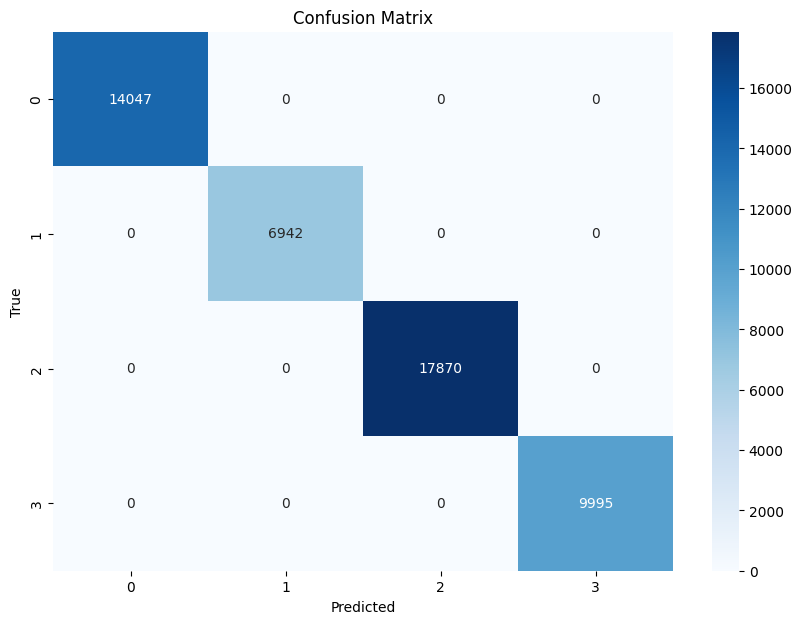

In [ ]:
# Confusion matrix for Training Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Accuracy, Precision, Recall, F1 Score for Testing Data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
              precision    recall  f1-score   support

           0       0.87      0.64      0.74       750
           1       0.62      0.55      0.58       750
           2       0.61      0.78      0.68       750
           3       0.78      0.84      0.81       750

    accuracy                           0.70      3000
   macro avg       0.72      0.70      0.70      3000
weighted avg       0.72      0.70      0.70      3000



4 layer (128, 64, 32, 16) 15 epochs
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       750
           1       0.66      0.40      0.50       750
           2       0.57      0.88      0.69       750
           3       0.89      0.83      0.86       750

    accuracy                           0.73      3000
   macro avg       0.75      0.73      0.72      3000
weighted avg       0.75      0.73      0.72      3000

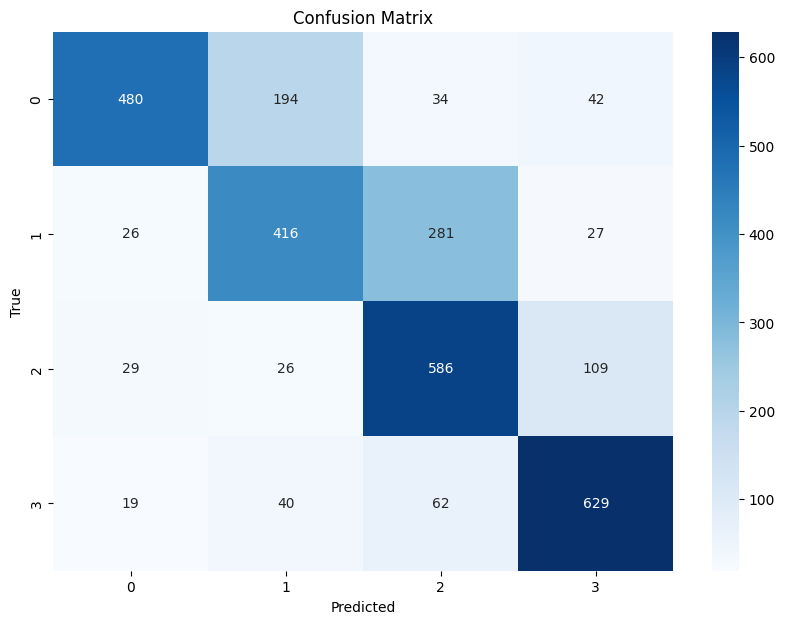

In [ ]:
# Confusion matrix for Testing Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()